# Libraries

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# Preprocessing

The original dataset 

In [2]:
df = pd.read_csv(f'data{os.sep}heart.csv')

df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

df['ExerciseAngina'] = df['ExerciseAngina'].apply(
    lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(
    lambda x: False if x == 0 else True)

df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)
df["Age"] = pd.qcut(x=df["Age"], q=2, labels=["young", "old"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, 1000], labels=[
                         "normal", "high", "very high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[
                           0, 200, 240, 1000], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.cut(x=df["MaxHR"], bins=3)
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=3, labels=[
                       "low", "medium", "high"])

In [3]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## Building the Bayesian Network with Hill Climbing

Hill Climbing is an algorithm used to learn the structure of the network, based on iterative improvements (iterations) until a local otpima is found, based on a scoring method that needs to be maximized.

It can be a useful tool to automatize the building of the network, especially if there is no (or little) knowledge of the domain.

Firstly, since pgmpy is quite a verbose library, there's the need to ignore some warnings that would otherwise occupy too much space.

In [4]:
import logging
from warnings import filterwarnings
logger = logging.getLogger('pgmpy')
logger.setLevel(logging.ERROR)
filterwarnings('ignore')

Then, since the KFold is used to determine the ROC AUC score, it's useful to write a function that takes as input the folding and the model, and returns the average score (taking each fold into account).

MLE is used in order to estimate the distribution parameters.

In [7]:
from sklearn.model_selection import KFold

kfold = KFold(10, shuffle=True, random_state=42)

def bayesian_kfold(kfold, model):
    score = []
    for train, test in kfold.split(df):
        model.fit(df.iloc[train, :], estimator=MaximumLikelihoodEstimator)
        y_pred = model.predict(df.iloc[test, :-1])
        score.append(roc_auc_score(df.iloc[test, -1], y_pred[target_variable]))
    return sum(score) / len(score)

For Hill Climbing there are the following scoring methods:
- k2score
- bdeuscore
- bdsscore
- bicscore
- aicscore

For each one of these scores, Hill Climbing will learn a network. Then, the networks will be tested in order to get the score method whose network performs better.

In [8]:
%%capture

scores = {} # Dictionary to store the roc_auc_score for each scoring method
networks = {} # Dictionary to store the network structure for each scoring method

for scoring in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(df, use_cache=False).estimate(scoring_method=scoring)
    networks[scoring] = network    
    model = BayesianNetwork(network)
    scores[scoring] = bayesian_kfold(kfold, model)


/home/antonio/anaconda3/lib/python3.11/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/antonio/anaconda3/lib/python3.11/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/antonio/anaconda3/lib/python3.11/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/antonio/anaconda3/lib/python3.11/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:491: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


It's also useful to look at the networks.

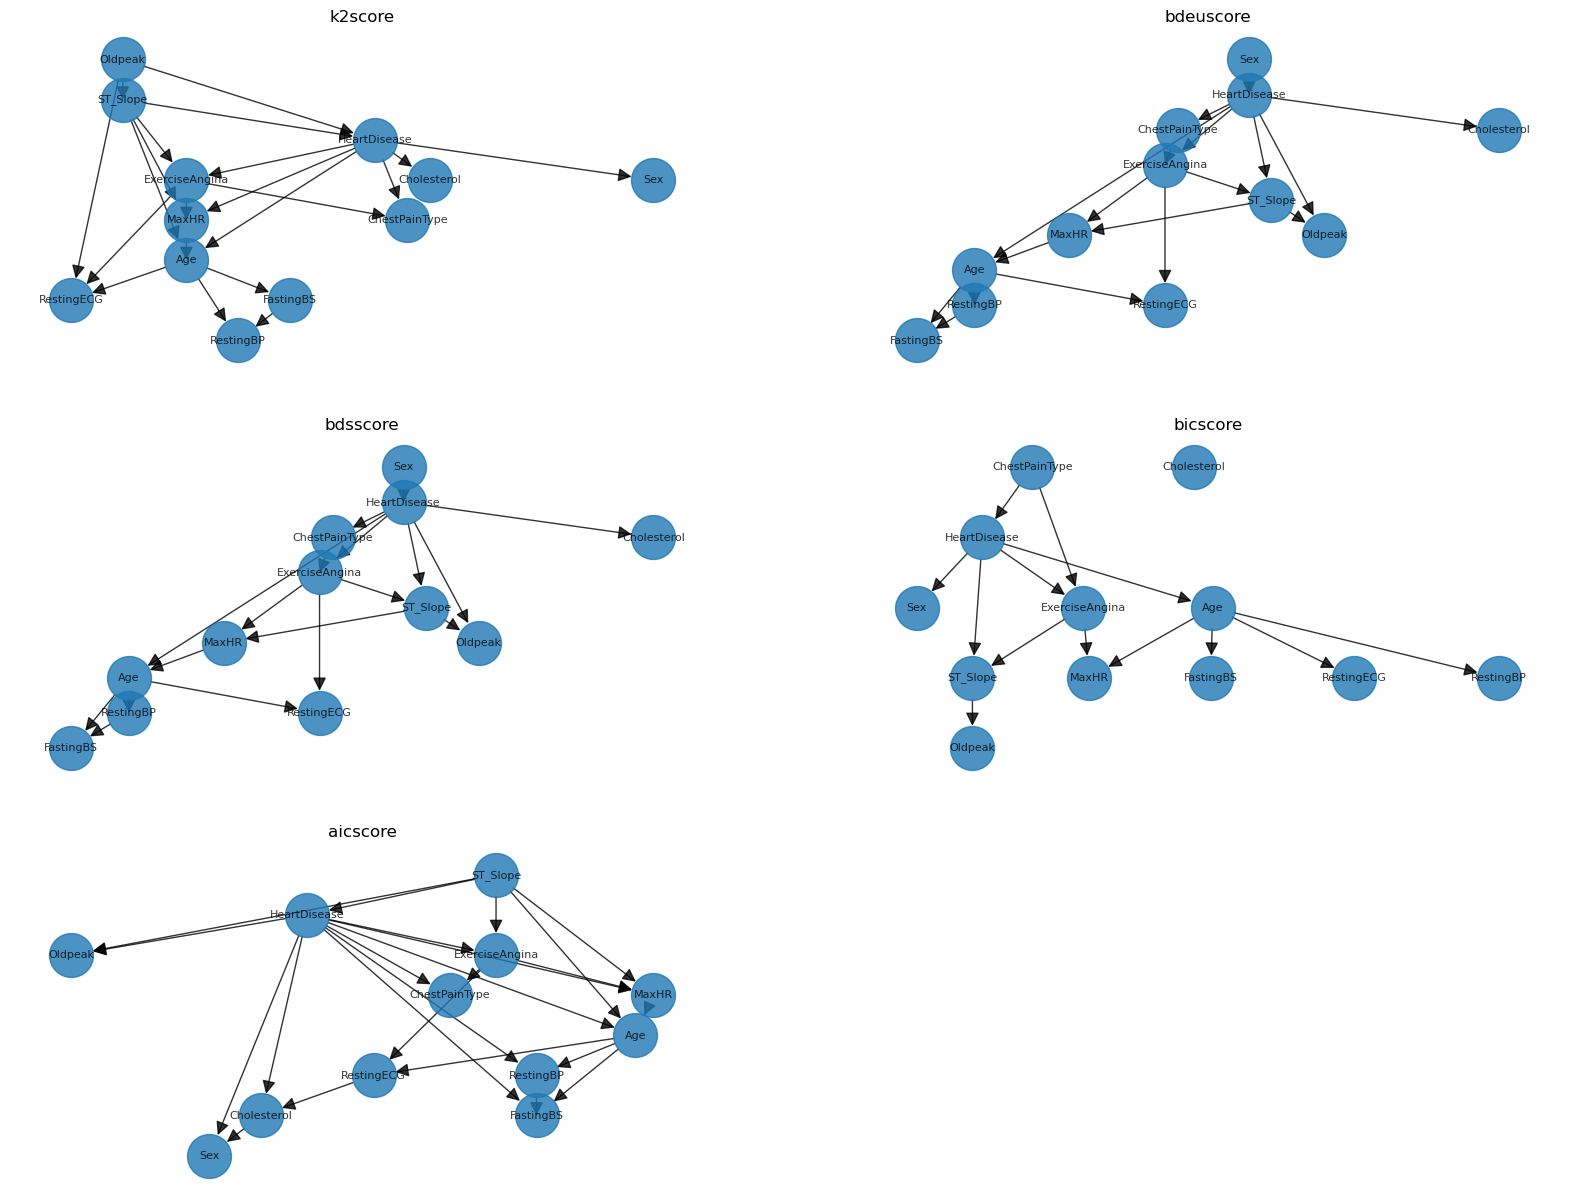

In [9]:
fig = plt.figure(figsize=(20,15))
i = 1
for scoring in networks:
    plt.subplot(3,2,i)
    pos = nx.nx_agraph.graphviz_layout(networks[scoring], prog="dot")
    nx.draw(networks[scoring], pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8) 
    plt.title(scoring) 
    i += 1
plt.show()

In all of them, there are some weird arches. For example, the nodes 'Age' and 'Sex' should not have parent nodes. This means that Hill Climbing learns a structure that may even have good performance, but it does not have (in most cases) semantical correctness.

Now let's compare the ROC AUC for each scoring method.

In [11]:
pd.DataFrame(scores, index = ['ROC AUC'])

,k2score,bdeuscore,bdsscore,bicscore,aicscore
ROC AUC,0.854186,0.86191,0.86191,0.859078,0.846054


From the results below wone can notice that they have an overall similar ROC AUC score. However, the networks are kinda different from each other and for each network there are some problems with the semantics. This means that:
- the choice of the scoring method does not influence so much the performance, even if the structures of the networks are different
- since the semantic is problematic, we need to add some constraint through blacklist/whitelist, so we cannot fully automatize the construction of the network 

So we can take as scoring method 'bdeuscore' and build an unconstraied network which we can improve manually (since it returns the higher ROC AUC score).